# A Level-2 Sea Ice Drift (SIED) algorithm for CIMR

This notebook implements a prototype for a Level-2 SIED algorithm for the CIMR mission.

We refer to the corresponding [ATBD](https://cimr-algos.github.io/SeaIceDrift_ATBD/intro.html) and especially the [Baseline Algorithm Definition](https://cimr-algos.github.io/SeaIceDrift_ATBD/baseline_algorithm_definition.html#baseline-algorithm-definition).

In particular, the figure below illustrates the overall concept of the processing:
<img src="https://cimr-algos.github.io/SeaIceDrift_ATBD/_images/CIMR_L2_Sea_Ice_Drift_Flow_Diagram.png" width="100%"/>

## Settings

Imports and general settings

In [1]:
%load_ext cython

In [2]:
# Root of directory and paths

import os
cpath = '/home/emilyjd/cimr-devalgo'
algpath = os.path.join(cpath, 'SeaIceDrift_ATBD_v2/algorithm/src_sied')
toolpath = os.path.join(cpath, 'Tools')

l1bpath = os.path.join(cpath, 'data/L1B')
concpath = os.path.join(cpath, 'data/conc')
icemaskpath = os.path.join(cpath, 'data/icemask')
swathpath = os.path.join(cpath, 'data/swaths')
driftpath = os.path.join(cpath, 'data/icedrift')
logpath = os.path.join(cpath, 'data/logs')

In [3]:
# Imports

from importlib import reload

import sys
import shutil
import numpy as np
import numpy.ma as ma
import xarray as xr
from netCDF4 import Dataset
from matplotlib import pylab as plt
import matplotlib.cm as cm
#import cmocean
from pyresample import parse_area_file
from datetime import datetime, timedelta

# Local modules contain software code that implement the SIED algorithm
if algpath not in sys.path:
    sys.path.insert(0, algpath)
#from src_sied import *
from icedrift_wrapper import icedrift_wrapper

# prototype re-gridding toolbox to handle the L1B input
if toolpath not in sys.path:
    sys.path.insert(0, toolpath)
from tools import io_handler as io
from tools import collocation as coll

In [4]:
# Plot settings

import matplotlib
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10) 
matplotlib.rcParams.update({'font.size': 12})
matplotlib.rcParams.update({'axes.labelsize': 12})

font = {'family' : 'sans',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)
cmap = cm.viridis

## Parametrize the run

User-set parameters for the running of the whole notebook

In [5]:
hemi = 'nh'
algos = {'KU': {'channels':('tb19v', 'tb19h'), 'target_band':'KU'},
         'KA': {'channels':('tb37v', 'tb37h'), 'target_band':'KA'}}

# DEVALGO's simulated geometric test card
#l1bfn = 'W_PT-DME-Lisbon-SAT-CIMR-1B_C_DME_20230417T105425_LD_20280110T114800_20280110T115700_TN.nc'
# DEVALGO's simulated radiometric test card
l1bfn = 'W_PT-DME-Lisbon-SAT-CIMR-1B_C_DME_20230420T103323_LD_20280110T114800_20280110T115700_TN.nc'

#dt = datetime.strptime('20230417T105425', '%Y%m%dT%H%M%S')
dt = datetime.strptime('20230420T103323', '%Y%m%dT%H%M%S')

l1bfile = os.path.join(l1bpath,l1bfn)

pdate = datetime.strptime('20280110', '%Y%m%d')
qdate = pdate + timedelta(days=1)

# Icemask data and output locations
icemaskinput = os.path.join(concpath, 'ice_conc_{}_ease-125_reproc_{:%Y%m%d}1200.nc'.format(hemi, pdate))
icemaskgridfile = os.path.join(algpath, 'grids_py.def')

## Step 1: Pre-processing (Icemask, loading the files, Laplacian pre-processing)


### Step 1a: Creating and regridding the ice mask


In [6]:
# Creating the ice mask

from process_ice_mask import process_ice_mask
gridname = '{}-ease2-050'.format(hemi)
process_ice_mask(icemaskinput, icemaskpath, icemaskgridfile, gridname)

/modules/rhel8/conda/install/envs/production-08-2023/lib/python3.9/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/modules/rhel8/conda/install/envs/production-08-2023/lib/python3.9/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


In [7]:
# Reading in the ice mask

icemaskname = os.path.join(icemaskpath, 'icemask-multi-{}-{:%Y%m%d}12.nc'.format(gridname, pdate))
ie_data = Dataset(icemaskname, 'r')
ie = ie_data['ice_edge'][0, :, :]
ieflip = np.flip(ie, axis=0)

Text(0.5, 1.0, 'Flipped ice mask')

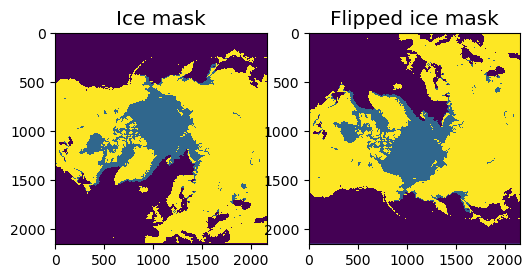

In [8]:
# Plotting the ice mask

fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(1,2,1)
c1 = ax1.imshow(ie[:], interpolation = 'none', cmap=cmap)
ax1.set_title("Ice mask")
ax2 = fig.add_subplot(1,2,2)
c2 = ax2.imshow(ieflip[:], interpolation = 'none', cmap=cmap)
ax2.set_title("Flipped ice mask")

/modules/rhel8/conda/install/envs/production-08-2023/lib/python3.9/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


Text(0.5, 1.0, 'Flipped ice mask on output grid')

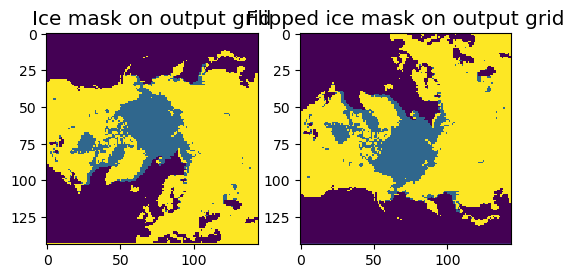

In [9]:
# Creating an output grid ice mask

gridnameout = '{}-ease2-750'.format(hemi)
process_ice_mask(icemaskinput, icemaskpath, icemaskgridfile, gridnameout)
icemasknameout = os.path.join(icemaskpath, 'icemask-multi-{}-{:%Y%m%d}12.nc'.format(gridnameout, pdate))
ie_data_out = Dataset(icemasknameout, 'r')
ieout = ie_data_out['ice_edge'][0, :, :]
ieoutflip = np.flip(ieout, axis=0)

fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(1,2,1)
c1 = ax1.imshow(ieout[:], interpolation = 'none', cmap=cmap)
ax1.set_title("Ice mask on output grid")
ax2 = fig.add_subplot(1,2,2)
c2 = ax2.imshow(ieoutflip[:], interpolation = 'none', cmap=cmap)
ax2.set_title("Flipped ice mask on output grid")


### Step 1b: Loading the data


In [10]:
# Read the bands needed of the L1B data
reload(io)

tb_dict = {'tb01':'L', 'tb06':'C', 'tb10':'X', 'tb19':'KU', 'tb37':'KA'}
rev_tb_dict = {v:k for k,v in tb_dict.items()}
bands_needed = []
for alg in algos.keys():
    bands_needed += algos[alg]['channels']
bands_needed = list(set([tb_dict[b[:-1]] for b in bands_needed]))

full_l1b = io.CIMR_L1B(l1bfile, selected_bands=bands_needed, keep_calibration_view=True)

In [11]:
# Split into forward / backward scan

fwd_l1b, bck_l1b = full_l1b.split_forward_backward_scans(method='horn_scan_angle')

### Step 1c: Regridding the data

In [12]:
# Regridding the data

reload(coll)

# Reshaping
fwd_l1b_r = fwd_l1b.reshape_interleave_feed()
bck_l1b_r = bck_l1b.reshape_interleave_feed()

# Loading the target grid information
gridname = '{}-ease2-050'.format(hemi)
new_area_def = parse_area_file(icemaskgridfile, gridname)[0]
new_lons, new_lats = new_area_def.get_lonlats()

# Getting the input lat/lons
fwd_ku_lat = fwd_l1b_r.data['KU']['lat'].data
fwd_ku_lon = fwd_l1b_r.data['KU']['lon'].data
bck_ku_lat = bck_l1b_r.data['KU']['lat'].data
bck_ku_lon = bck_l1b_r.data['KU']['lon'].data
fwd_ka_lat = fwd_l1b_r.data['KA']['lat'].data
fwd_ka_lon = fwd_l1b_r.data['KA']['lon'].data
bck_ka_lat = bck_l1b_r.data['KA']['lat'].data
bck_ka_lon = bck_l1b_r.data['KA']['lon'].data

# Creating data arrays with the V and H layers
what = ('brightness_temperature_v', 'brightness_temperature_h')
fwd_ku_stack_shape = tuple(list(fwd_ku_lat.shape) + [len(what),])
bck_ku_stack_shape = tuple(list(bck_ku_lat.shape) + [len(what),])
fwd_ka_stack_shape = tuple(list(fwd_ka_lat.shape) + [len(what),])
bck_ka_stack_shape = tuple(list(bck_ka_lat.shape) + [len(what),])
fwd_ku_stack = np.empty(fwd_ku_stack_shape)
bck_ku_stack = np.empty(bck_ku_stack_shape)
fwd_ka_stack = np.empty(fwd_ka_stack_shape)
bck_ka_stack = np.empty(bck_ka_stack_shape)
for iw, w in enumerate(what):
    fwd_ku_stack[...,iw] = fwd_l1b_r.data['KU'][w].data
    bck_ku_stack[...,iw] = bck_l1b_r.data['KU'][w].data
    fwd_ka_stack[...,iw] = fwd_l1b_r.data['KA'][w].data
    bck_ka_stack[...,iw] = bck_l1b_r.data['KA'][w].data

# Regridding
params = {'method':'gauss', 'sigmas':25000, 'neighbours':55}
fwd_ku_regrid = coll._regrid_fields(new_lons, new_lats, fwd_ku_lon, fwd_ku_lat, fwd_ku_stack)
bck_ku_regrid = coll._regrid_fields(new_lons, new_lats, bck_ku_lon, bck_ku_lat, bck_ku_stack)
fwd_ka_regrid = coll._regrid_fields(new_lons, new_lats, fwd_ka_lon, fwd_ka_lat, fwd_ka_stack)
bck_ka_regrid = coll._regrid_fields(new_lons, new_lats, bck_ka_lon, bck_ka_lat, bck_ka_stack)

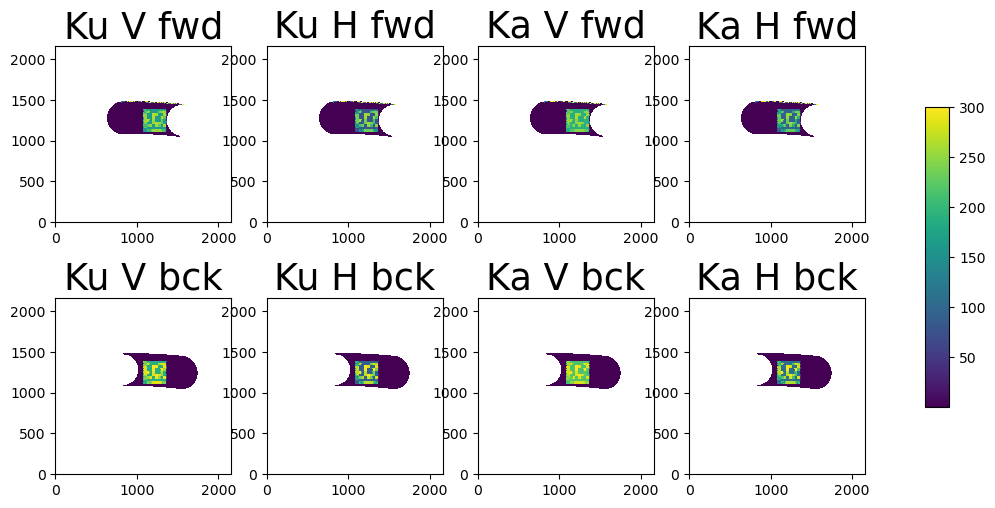

In [13]:
# Plot regridded

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(2,4,1)
c1 = ax1.imshow(fwd_ku_regrid[:, :, 0], interpolation = 'none', origin='lower', cmap=cmap)
ax1.set_title("Ku V fwd")
ax2 = fig.add_subplot(2,4,2)
c2 = ax2.imshow(fwd_ku_regrid[:, :, 1], interpolation = 'none', origin='lower', cmap=cmap)
ax2.set_title("Ku H fwd")
ax3 = fig.add_subplot(2,4,3)
c3 = ax3.imshow(fwd_ka_regrid[:, :, 0], interpolation = 'none', origin='lower', cmap=cmap)
ax3.set_title("Ka V fwd")
ax4 = fig.add_subplot(2,4,4)
c4 = ax4.imshow(fwd_ka_regrid[:, :, 1], interpolation = 'none', origin='lower', cmap=cmap)
ax4.set_title("Ka H fwd")

ax5 = fig.add_subplot(2,4,5)
c5 = ax5.imshow(bck_ku_regrid[:, :, 0], interpolation = 'none', origin='lower', cmap=cmap)
ax5.set_title("Ku V bck")
ax6 = fig.add_subplot(2,4,6)
c6 = ax6.imshow(bck_ku_regrid[:, :, 1], interpolation = 'none', origin='lower', cmap=cmap)
ax6.set_title("Ku H bck")
ax7 = fig.add_subplot(2,4,7)
c7 = ax7.imshow(bck_ka_regrid[:, :, 0], interpolation = 'none', origin='lower', cmap=cmap)
ax7.set_title("Ka V bck")
ax8 = fig.add_subplot(2,4,8)
c8 = ax8.imshow(bck_ka_regrid[:, :, 1], interpolation = 'none', origin='lower', cmap=cmap)
ax8.set_title("Ka H bck")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.25, 0.02, 0.5])
fig.colorbar(c1, cax=cbar_ax, shrink=0.5)


# Step 1d: Laplacian pre-processing


In [14]:
# Laplacian pre-processing

from scipy.ndimage import laplace


# Replace fill value by NaN and remove mask
def _get_nans(img):
    img_masked = np.ma.asarray(img)
    return img_masked.filled(np.nan)

# Replace NaN by fill value and add mask
def _mask_nans(img):
    return np.ma.masked_invalid(img)


# Convert fill values to NaNs
fwd_ku_nan = _get_nans(fwd_ku_regrid)
bck_ku_nan = _get_nans(bck_ku_regrid)
fwd_ka_nan = _get_nans(fwd_ka_regrid)
bck_ka_nan = _get_nans(bck_ka_regrid)

# Laplacian transform
fwd_ku_lap = laplace(fwd_ku_nan)
bck_ku_lap = laplace(bck_ku_nan)
fwd_ka_lap = laplace(fwd_ka_nan)
bck_ka_lap = laplace(bck_ka_nan)

# Converting NaNs to fill values
fwd_ku_fv = _mask_nans(fwd_ku_lap)
bck_ku_fv = _mask_nans(bck_ku_lap)
fwd_ka_fv = _mask_nans(fwd_ka_lap)
bck_ka_fv = _mask_nans(bck_ka_lap)

# Creating a flag field
#define TCIMAGE_OUTSIDE_GRID              -2
#define TCIMAGE_NODATA                    -1
#define TCIMAGE_OK                         0
#define TCIMAGE_UNPROCESSED                1
#define TCIMAGE_FAILED                     2
fwd_ku_flag = np.zeros_like(fwd_ku_fv)
bck_ku_flag = np.zeros_like(bck_ku_fv)
fwd_ka_flag = np.zeros_like(fwd_ka_fv)
bck_ka_flag = np.zeros_like(bck_ka_fv)
# Masking where the Laplacian didn't work
fwd_ku_flag[fwd_ku_fv.mask] = -1
bck_ku_flag[bck_ku_fv.mask] = -1
fwd_ka_flag[fwd_ka_fv.mask] = -1
bck_ka_flag[bck_ka_fv.mask] = -1
# Masking where the land and ocean is
landocean = np.logical_or(ieflip == 9, ieflip == 1)
fwd_ku_flag[landocean] = 1
bck_ku_flag[landocean] = 1
fwd_ka_flag[landocean] = 1
bck_ka_flag[landocean] = 1
#TODO - The ocean not masked in landocean (but masked by NODATA, so don't worry now)

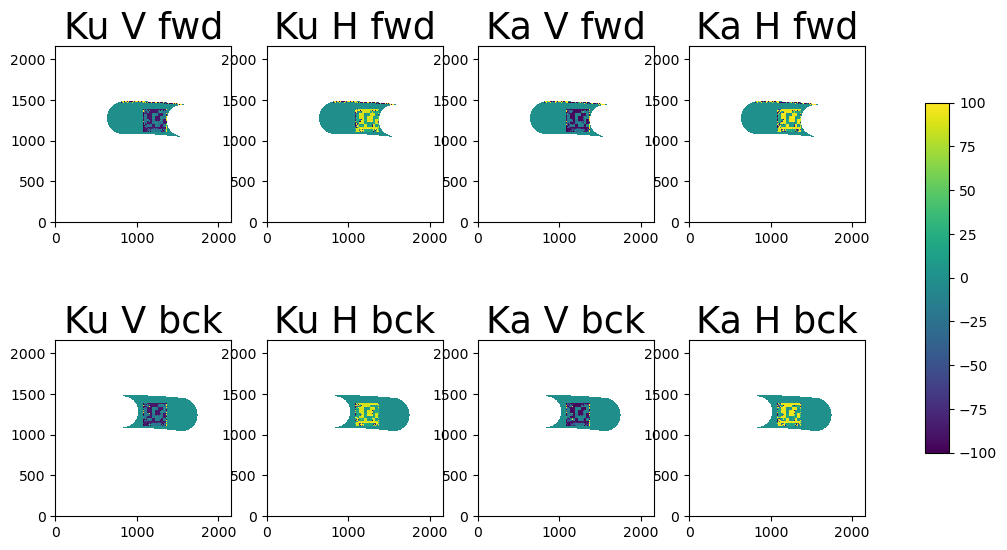

In [15]:
# Plot Laplacian

vmin = -100
vmax = 100

fig = plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(2,4,1)
c1 = ax1.imshow(fwd_ku_fv[:, :, 0], interpolation = 'none', origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
ax1.set_title("Ku V fwd")
ax2 = fig.add_subplot(2,4,2)
c2 = ax2.imshow(fwd_ku_fv[:, :, 1], interpolation = 'none', origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
ax2.set_title("Ku H fwd")
ax3 = fig.add_subplot(2,4,3)
c3 = ax3.imshow(fwd_ka_fv[:, :, 0], interpolation = 'none', origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
ax3.set_title("Ka V fwd")
ax4 = fig.add_subplot(2,4,4)
c4 = ax4.imshow(fwd_ka_fv[:, :, 1], interpolation = 'none', origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
ax4.set_title("Ka H fwd")

ax5 = fig.add_subplot(2,4,5)
c5 = ax5.imshow(bck_ku_fv[:, :, 0], interpolation = 'none', origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
ax5.set_title("Ku V bck")
ax6 = fig.add_subplot(2,4,6)
c6 = ax6.imshow(bck_ku_fv[:, :, 1], interpolation = 'none', origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
ax6.set_title("Ku H bck")
ax7 = fig.add_subplot(2,4,7)
c7 = ax7.imshow(bck_ka_fv[:, :, 0], interpolation = 'none', origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
ax7.set_title("Ka V bck")
ax8 = fig.add_subplot(2,4,8)
c8 = ax8.imshow(bck_ka_fv[:, :, 1], interpolation = 'none', origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
ax8.set_title("Ka H bck")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.25, 0.02, 0.5])
fig.colorbar(c1, cax=cbar_ax, shrink=0.5)

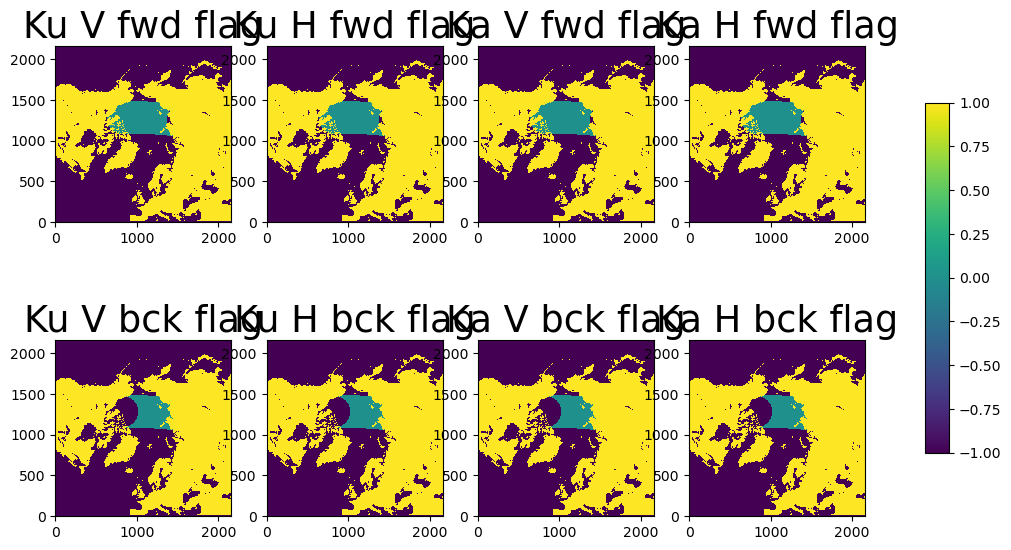

In [16]:
# Plot Laplacian flags

fig = plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(2,4,1)
c1 = ax1.imshow(fwd_ku_flag[:, :, 0], interpolation = 'none', origin='lower', cmap=cmap)
ax1.set_title("Ku V fwd flag")
ax2 = fig.add_subplot(2,4,2)
c2 = ax2.imshow(fwd_ku_flag[:, :, 1], interpolation = 'none', origin='lower', cmap=cmap)
ax2.set_title("Ku H fwd flag")
ax3 = fig.add_subplot(2,4,3)
c3 = ax3.imshow(fwd_ka_flag[:, :, 0], interpolation = 'none', origin='lower', cmap=cmap)
ax3.set_title("Ka V fwd flag")
ax4 = fig.add_subplot(2,4,4)
c4 = ax4.imshow(fwd_ka_flag[:, :, 1], interpolation = 'none', origin='lower', cmap=cmap)
ax4.set_title("Ka H fwd flag")

ax5 = fig.add_subplot(2,4,5)
c5 = ax5.imshow(bck_ku_flag[:, :, 0], interpolation = 'none', origin='lower', cmap=cmap)
ax5.set_title("Ku V bck flag")
ax6 = fig.add_subplot(2,4,6)
c6 = ax6.imshow(bck_ku_flag[:, :, 1], interpolation = 'none', origin='lower', cmap=cmap)
ax6.set_title("Ku H bck flag")
ax7 = fig.add_subplot(2,4,7)
c7 = ax7.imshow(bck_ka_flag[:, :, 0], interpolation = 'none', origin='lower', cmap=cmap)
ax7.set_title("Ka V bck flag")
ax8 = fig.add_subplot(2,4,8)
c8 = ax8.imshow(bck_ka_flag[:, :, 1], interpolation = 'none', origin='lower', cmap=cmap)
ax8.set_title("Ka H bck flag")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.25, 0.02, 0.5])
fig.colorbar(c1, cax=cbar_ax, shrink=0.5)


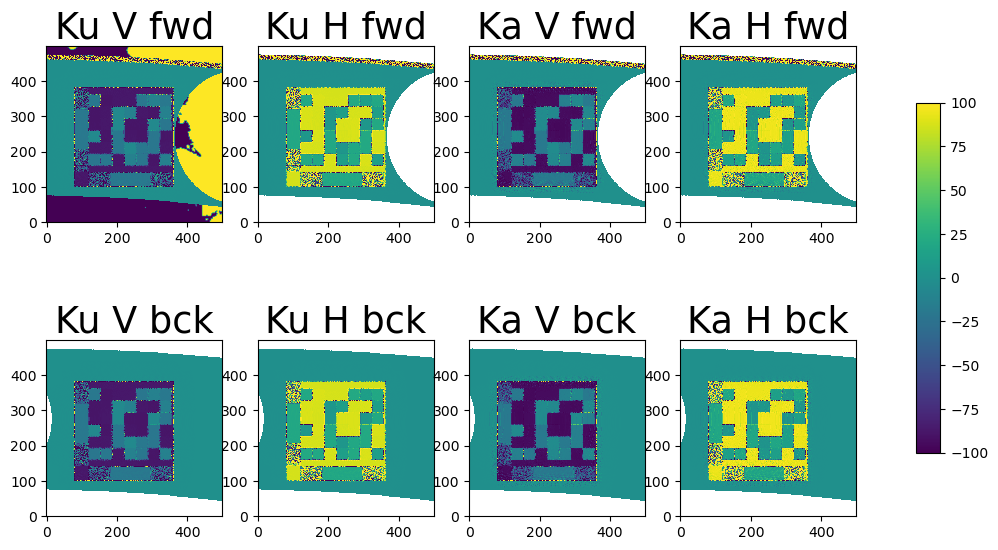

In [17]:
# Plot Laplacian zoomed

fig = plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(2,4,1)
c1 = ax1.imshow(fwd_ku_fv[1000:1500, 1000:1500, 0], interpolation = 'none', origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
ax1.imshow(ieflip[1000:1500, 1000:1500])
ax1.imshow(fwd_ku_fv[1000:1500, 1000:1500, 0], interpolation = 'none', origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
ax1.set_title("Ku V fwd")
ax2 = fig.add_subplot(2,4,2)
c2 = ax2.imshow(fwd_ku_fv[1000:1500, 1000:1500, 1], interpolation = 'none', origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
ax2.set_title("Ku H fwd")
ax3 = fig.add_subplot(2,4,3)
c3 = ax3.imshow(fwd_ka_fv[1000:1500, 1000:1500, 0], interpolation = 'none', origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
ax3.set_title("Ka V fwd")
ax4 = fig.add_subplot(2,4,4)
c4 = ax4.imshow(fwd_ka_fv[1000:1500, 1000:1500, 1], interpolation = 'none', origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
ax4.set_title("Ka H fwd")

ax5 = fig.add_subplot(2,4,5)
c5 = ax5.imshow(bck_ku_fv[1000:1500, 1000:1500, 0], interpolation = 'none', origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
ax5.set_title("Ku V bck")
ax6 = fig.add_subplot(2,4,6)
c6 = ax6.imshow(bck_ku_fv[1000:1500, 1000:1500, 1], interpolation = 'none', origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
ax6.set_title("Ku H bck")
ax7 = fig.add_subplot(2,4,7)
c7 = ax7.imshow(bck_ka_fv[1000:1500, 1000:1500, 0], interpolation = 'none', origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
ax7.set_title("Ka V bck")
ax8 = fig.add_subplot(2,4,8)
c8 = ax8.imshow(bck_ka_fv[1000:1500, 1000:1500, 1], interpolation = 'none', origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
ax8.set_title("Ka H bck")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.25, 0.02, 0.5])
fig.colorbar(c1, cax=cbar_ax, shrink=0.5)

# Step 1e: Writing out the file


In [18]:
crs_info = {'proj4_string': new_area_def.proj4_string,
             'area_id': new_area_def.area_id,
             'semi_major_axis': 6378137.,
             'semi_minor_axis': 6356752.31424518,
             'inverse_flattening': 298.257223563,
             'reference_ellipsoid_name': "WGS 84",
             'longitude_of_prime_meridian': 0.,
             'prime_meridian_name': "Greenwich",
             'geographic_crs_name': "unknown",
             'horizontal_datum_name': "World Geodetic System 1984",
             'projected_crs_name': "unknown",
             'grid_mapping_name': "lambert_azimuthal_equal_area",
             'latitude_of_projection_origin': 90.,
             'longitude_of_projection_origin': 0.,
             'false_easting': 0.,
             'false_northing': 0.}

/modules/rhel8/conda/install/envs/production-08-2023/lib/python3.9/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


In [19]:
ds = xr.Dataset(
    data_vars=dict(
        tb19vfw=(["xc", "yc"], fwd_ku_regrid[:, :, 0]),
        tb19vbk=(["xc", "yc"], bck_ku_regrid[:, :, 0]),
        tb19hfw=(["xc", "yc"], fwd_ku_regrid[:, :, 1]),
        tb19hbk=(["xc", "yc"], bck_ku_regrid[:, :, 1]),
        tb37vfw=(["xc", "yc"], fwd_ka_regrid[:, :, 0]),
        tb37vbk=(["xc", "yc"], bck_ka_regrid[:, :, 0]),
        tb37hfw=(["xc", "yc"], fwd_ka_regrid[:, :, 1]),
        tb37hbk=(["xc", "yc"], bck_ka_regrid[:, :, 1]),
        tb19vfw_lap=(["xc", "yc"], fwd_ku_fv[:, :, 0]),
        tb19vbk_lap=(["xc", "yc"], bck_ku_fv[:, :, 0]),
        tb19hfw_lap=(["xc", "yc"], fwd_ku_fv[:, :, 1]),
        tb19hbk_lap=(["xc", "yc"], bck_ku_fv[:, :, 1]),
        tb37vfw_lap=(["xc", "yc"], fwd_ka_fv[:, :, 0]),
        tb37vbk_lap=(["xc", "yc"], bck_ka_fv[:, :, 0]),
        tb37hfw_lap=(["xc", "yc"], fwd_ka_fv[:, :, 1]),
        tb37hbk_lap=(["xc", "yc"], bck_ka_fv[:, :, 1]),
        tb19vfw_lap_flag=(["xc", "yc"], fwd_ku_flag[:, :, 0]),
        tb19vbk_lap_flag=(["xc", "yc"], bck_ku_flag[:, :, 0]),
        tb19hfw_lap_flag=(["xc", "yc"], fwd_ku_flag[:, :, 1]),
        tb19hbk_lap_flag=(["xc", "yc"], bck_ku_flag[:, :, 1]),
        tb37vfw_lap_flag=(["xc", "yc"], fwd_ka_flag[:, :, 0]),
        tb37vbk_lap_flag=(["xc", "yc"], bck_ka_flag[:, :, 0]),
        tb37hfw_lap_flag=(["xc", "yc"], fwd_ka_flag[:, :, 1]),
        tb37hbk_lap_flag=(["xc", "yc"], bck_ka_flag[:, :, 1]),
        dtime=(["xc", "yc"], np.full_like(fwd_ku_regrid[:, :, 0], pdate.timestamp())),
        ice_edge=(["xc", "yc"], ieflip),
        crs=([], 0),
        time=(["xc"], np.full_like(fwd_ku_regrid[:, 0, 0], pdate.timestamp()))
    ),
    coords=dict(
        lon=(["xc", "yc"], new_lons),
        lat=(["xc", "yc"], new_lats),
    ),
    attrs=dict(description="Variables for CMCC",
               datetime=datetime.strftime(pdate, '%Y%m%d')),
)
ds['xc'] = new_area_def.projection_x_coords
ds['xc'].attrs = {'units': 'm'}
ds['yc'] = new_area_def.projection_y_coords
ds['yc'].attrs = {'units': 'm'}
ds['crs'].attrs = crs_info
ds['dtime'].attrs = {'units': "seconds since 1970-01-01 00:00:00"}
ds['time'].attrs = {'units': "seconds since 1970-01-01 00:00:00"}

dsname = os.path.join(swathpath, 'bt_{}_{:%Y%m%d}.nc'.format(gridname, pdate))
ds.to_netcdf(dsname, 'w', format="NETCDF3_CLASSIC")

### Step 1f (temporary): Creating a test gridded file with "time difference" 24h and 1 px added in each x and y


In [20]:
tempds = xr.Dataset(
    data_vars=dict(
        tb19vfw_fmsk=(["xc", "yc"], fwd_ku_fv[:, :, 0].mask),
        tb19vbk_fmsk=(["xc", "yc"], bck_ku_fv[:, :, 0].mask),
        tb19hfw_fmsk=(["xc", "yc"], fwd_ku_fv[:, :, 1].mask),
        tb19hbk_fmsk=(["xc", "yc"], bck_ku_fv[:, :, 1].mask),
        tb37vfw_fmsk=(["xc", "yc"], fwd_ka_fv[:, :, 0].mask),
        tb37vbk_fmsk=(["xc", "yc"], bck_ka_fv[:, :, 0].mask),
        tb37hfw_fmsk=(["xc", "yc"], fwd_ka_fv[:, :, 1].mask),
        tb37hbk_fmsk=(["xc", "yc"], bck_ka_fv[:, :, 1].mask),
        dtime=(["xc", "yc"], np.full_like(fwd_ku_regrid[:, :, 0], pdate.timestamp())),
        ice_edge=(["xc", "yc"], ieflip),
        crs=([], 0),
        time=(["xc"], np.full_like(fwd_ku_regrid[:, 0, 0], pdate.timestamp()))
    ),
    coords=dict(
        lon=(["xc", "yc"], new_lons),
        lat=(["xc", "yc"], new_lats),
    ),
    attrs=dict(description="Variables for CMCC",
               datetime=datetime.strftime(pdate, '%Y%m%d')),
)
tempds['xc'] = new_area_def.projection_x_coords
tempds['xc'].attrs = {'units': 'm'}
tempds['yc'] = new_area_def.projection_y_coords
tempds['yc'].attrs = {'units': 'm'}
tempds['crs'].attrs = crs_info
tempds['dtime'].attrs = {'units': "seconds since 1970-01-01 00:00:00"}
tempds['time'].attrs = {'units': "seconds since 1970-01-01 00:00:00"}


pixshx = 5
pixshy = 5

# Shift can be used in xarray to shift dimension by number of pix. Note that the dimensions must be called x and y within xarray
tb19vfw_shft = ds.tb19vfw.shift(xc=pixshx, yc=pixshy)
tb19vbk_shft = ds.tb19vbk.shift(xc=pixshx, yc=pixshy)
tb19hfw_shft = ds.tb19hfw.shift(xc=pixshx, yc=pixshy)
tb19hbk_shft = ds.tb19hbk.shift(xc=pixshx, yc=pixshy)
tb37vfw_shft = ds.tb37vfw.shift(xc=pixshx, yc=pixshy)
tb37vbk_shft = ds.tb37vbk.shift(xc=pixshx, yc=pixshy)
tb37hfw_shft = ds.tb37hfw.shift(xc=pixshx, yc=pixshy)
tb37hbk_shft = ds.tb37hbk.shift(xc=pixshx, yc=pixshy)
tb19vfw_lap_shft = ds.tb19vfw_lap.shift(xc=pixshx, yc=pixshy)
tb19vbk_lap_shft = ds.tb19vbk_lap.shift(xc=pixshx, yc=pixshy)
tb19hfw_lap_shft = ds.tb19hfw_lap.shift(xc=pixshx, yc=pixshy)
tb19hbk_lap_shft = ds.tb19hbk_lap.shift(xc=pixshx, yc=pixshy)
tb37vfw_lap_shft = ds.tb37vfw_lap.shift(xc=pixshx, yc=pixshy)
tb37vbk_lap_shft = ds.tb37vbk_lap.shift(xc=pixshx, yc=pixshy)
tb37hfw_lap_shft = ds.tb37hfw_lap.shift(xc=pixshx, yc=pixshy)
tb37hbk_lap_shft = ds.tb37hbk_lap.shift(xc=pixshx, yc=pixshy)

# Flag field (want the data shifted, the landmask not)
tb19vfw_lap_flag_shft = np.zeros_like(tb19vfw_lap_shft)
tb19vbk_lap_flag_shft = np.zeros_like(tb19vbk_lap_shft)
tb19hfw_lap_flag_shft = np.zeros_like(tb19hfw_lap_shft)
tb19hbk_lap_flag_shft = np.zeros_like(tb19hbk_lap_shft)
tb37vfw_lap_flag_shft = np.zeros_like(tb37vfw_lap_shft)
tb37vbk_lap_flag_shft = np.zeros_like(tb37vbk_lap_shft)
tb37hfw_lap_flag_shft = np.zeros_like(tb37hfw_lap_shft)
tb37hbk_lap_flag_shft = np.zeros_like(tb37hbk_lap_shft)
# Masking where the Laplacian failed
tb19vfw_fmsk_shft = tempds.tb19vfw_fmsk.shift(xc=pixshx, yc=pixshy)
tb19vbk_fmsk_shft = tempds.tb19vbk_fmsk.shift(xc=pixshx, yc=pixshy)
tb19hfw_fmsk_shft = tempds.tb19hfw_fmsk.shift(xc=pixshx, yc=pixshy)
tb19hbk_fmsk_shft = tempds.tb19hbk_fmsk.shift(xc=pixshx, yc=pixshy)
tb37vfw_fmsk_shft = tempds.tb37vfw_fmsk.shift(xc=pixshx, yc=pixshy)
tb37vbk_fmsk_shft = tempds.tb37vbk_fmsk.shift(xc=pixshx, yc=pixshy)
tb37hfw_fmsk_shft = tempds.tb37hfw_fmsk.shift(xc=pixshx, yc=pixshy)
tb37hbk_fmsk_shft = tempds.tb37hbk_fmsk.shift(xc=pixshx, yc=pixshy)
tb19vfw_lap_flag_shft[tb19vfw_fmsk_shft == 1] = -1
tb19vbk_lap_flag_shft[tb19vbk_fmsk_shft == 1] = -1
tb19hfw_lap_flag_shft[tb19hfw_fmsk_shft == 1] = -1
tb19hbk_lap_flag_shft[tb19hbk_fmsk_shft == 1] = -1
tb37vfw_lap_flag_shft[tb37vfw_fmsk_shft == 1] = -1
tb37vbk_lap_flag_shft[tb37vbk_fmsk_shft == 1] = -1
tb37hfw_lap_flag_shft[tb37hfw_fmsk_shft == 1] = -1
tb37hbk_lap_flag_shft[tb37hbk_fmsk_shft == 1] = -1
# Masking where the land and ocean is
landocean = np.logical_or(ieflip == 9, ieflip == 1)
tb19vfw_lap_flag_shft[landocean] = 1
tb19vbk_lap_flag_shft[landocean] = 1
tb19hfw_lap_flag_shft[landocean] = 1
tb19hbk_lap_flag_shft[landocean] = 1
tb37vfw_lap_flag_shft[landocean] = 1
tb37vbk_lap_flag_shft[landocean] = 1
tb37hfw_lap_flag_shft[landocean] = 1
tb37hbk_lap_flag_shft[landocean] = 1

ds['tb19vfw'].data = tb19vfw_shft
ds['tb19vbk'].data = tb19vbk_shft
ds['tb19hfw'].data = tb19hfw_shft
ds['tb19hbk'].data = tb19hbk_shft
ds['tb37vfw'].data = tb37vfw_shft
ds['tb37vbk'].data = tb37vbk_shft
ds['tb37hfw'].data = tb37hfw_shft
ds['tb37hbk'].data = tb37hbk_shft
ds['tb19vfw_lap'].data = tb19vfw_lap_shft
ds['tb19vbk_lap'].data = tb19vbk_lap_shft
ds['tb19hfw_lap'].data = tb19hfw_lap_shft
ds['tb19hbk_lap'].data = tb19hbk_lap_shft
ds['tb37vfw_lap'].data = tb37vfw_lap_shft
ds['tb37vbk_lap'].data = tb37vbk_lap_shft
ds['tb37hfw_lap'].data = tb37hfw_lap_shft
ds['tb37hbk_lap'].data = tb37hbk_lap_shft
ds['tb19vfw_lap_flag'].data = tb19vfw_lap_flag_shft
ds['tb19vbk_lap_flag'].data = tb19vbk_lap_flag_shft
ds['tb19hfw_lap_flag'].data = tb19hfw_lap_flag_shft
ds['tb19hbk_lap_flag'].data = tb19hbk_lap_flag_shft
ds['tb37vfw_lap_flag'].data = tb37vfw_lap_flag_shft
ds['tb37vbk_lap_flag'].data = tb37vbk_lap_flag_shft
ds['tb37hfw_lap_flag'].data = tb37hfw_lap_flag_shft
ds['tb37hbk_lap_flag'].data = tb37hbk_lap_flag_shft

# Shift time by 24h
ds.attrs['datetime'] = datetime.strftime(qdate, '%Y%m%d')
ds['dtime'].data = np.full_like(fwd_ku_regrid[:, :, 0], qdate.timestamp())
ds['time'].data = np.full_like(fwd_ku_regrid[:, 0, 0], qdate.timestamp())

dsname2 = os.path.join('bt_{}_{:%Y%m%d}.nc'.format(gridname, qdate))
ds.to_netcdf(dsname2, 'w', format="NETCDF3_CLASSIC")


## Step 2: Cross-correlation algorithm


In [21]:
### Step 2a: Select the pixels which can be cross-correlated


In [22]:
# (1) Mask the land
# (2) Mask the pixels which are not over ice in both the start and end images
# (3) Mask pixels where the start or end images are missing data

# Ice mask notation
# 0 - Open water/missing
# 3 - Open/close ice
# 9 - Land

# TODO - Check this is done correctly

### Step 2b: CMCC


In [23]:
# Copying the files with new names

chanstr = 'tb19hfw-tb19vfw-tb19hbk-tb19vbk-tb37hfw-tb37vfw-tb37hbk-tb37vbk'
newname1 = 'tc_wght_cimr-cimr_{}_{}-ease2-050_{}12.nc'.format(chanstr, hemi, datetime.strftime(pdate, '%Y%m%d'))
newname2 = 'tc_wght_cimr-cimr_{}_{}-ease2-050_{}12.nc'.format(chanstr, hemi, datetime.strftime(qdate, '%Y%m%d'))
shutil.copyfile(dsname, os.path.join(os.path.dirname(dsname), newname1))
shutil.copyfile(dsname2, os.path.join(os.path.dirname(dsname), newname2))

'/home/emilyjd/cimr-devalgo/data/swaths/tc_wght_cimr-cimr_tb19hfw-tb19vfw-tb19hbk-tb19vbk-tb37hfw-tb37vfw-tb37hbk-tb37vbk_nh-ease2-050_2028011112.nc'

In [24]:
%load_ext autoreload
%autoreload
from icedrift_wrapper import icedrift_wrapper


# TO DO - ADD GRID NEEDED TO pmr_gridding/etc/grids.def
chan_list = ['tb19hfw_lap']
idrift = icedrift_wrapper(pdate, qdate, swathpath, swathpath, driftpath, os.path.join(logpath, 'cmcc-test.log'),
                          'cimr-cimr', 'nh-ease2-050', chan_list, 75., 125.)


Daily maps found (cimr-cimr):

	Day 1 : /home/emilyjd/cimr-devalgo/data/swaths/tc_wght_cimr-cimr_tb19hfw-tb19vfw-tb19hbk-tb19vbk-tb37hfw-tb37vfw-tb37hbk-tb37vbk_nh-ease2-050_2028011012.nc 

	Day 2 : /home/emilyjd/cimr-devalgo/data/swaths/tc_wght_cimr-cimr_tb19hfw-tb19vfw-tb19hbk-tb19vbk-tb37hfw-tb37vfw-tb37hbk-tb37vbk_nh-ease2-050_2028011112.nc 



LATS =  [16.46457259 16.50441755 16.54423359 ... 16.54423359 16.50441755
 16.46457259]
LONS =  [-135.         -135.02655041 -135.05312542 ...   44.94687458   44.97344959
   45.        ]
FNAME =  /home/emilyjd/cimr-devalgo/data/swaths/tc_wght_cimr-cimr_tb19hfw-tb19vfw-tb19hbk-tb19vbk-tb37hfw-tb37vfw-tb37hbk-tb37vbk_nh-ease2-050_2028011012.nc
CHANNEL =  tb19hfw_lap
MIN IMAGE =  -1199.9866844911185
MAX IMAGE =  1199.9866844911185
MIN FLAG =  -1
MAX FLAG =  1
MIN AVTIME =  1831075200.0
MAX AVTIME =  1831075200.0
FNAME =  /home/emilyjd/cimr-devalgo/data/swaths/tc_wght_cimr-cimr_tb19hfw-tb19vfw-tb19hbk-tb19vbk-tb37hfw-tb37vfw-tb37hbk-tb37vbk_nh-e

/modules/rhel8/conda/install/envs/production-08-2023/lib/python3.9/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


###########################################################
projstr =  b'+proj=laea +lat_0=90 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m'
optimmetric =  b'CC'
out_area =  b'nhease750'
out_projstr =  b'+datum=WGS84 +lat_0=90 +lon_0=0 +proj=laea +units=m +x_0=0 +y_0=0'
clog =  b'/home/emilyjd/cimr-devalgo/data/logs/cmcc-test.log'
img_Ax =  5.0
img_Bx =  -5397.5
img_Ay =  5.0
img_By =  5397.5
nbWaveBands =  1
twghtStart =  1
twghtEnd =  1
maxdriftdistance =  38.88
sigmoid_length =  38.88
NDRIFTPIXELS =  20736
out_Ax =  75.0
out_Bx =  -5362.5
out_Ay =  75.0
out_By =  5362.5
radiusNeighbours =  125.0
===> obs[0][0][ 400499 ] =  nan
===> obs[0][0][ 400500 ] =  nan
===> obs[0][0][ 400501 ] =  nan
===> obs[1][0][ 400499 ] =  nan
===> obs[1][0][ 400500 ] =  nan
===> obs[1][0][ 400501 ] =  nan
===> TCflag[0][0][ 400499 ] =  -1
===> TCflag[0][0][ 400500 ] =  -1
===> TCflag[0][0][ 400501 ] =  -1
===> TCflag[1][0][ 400499 ] =  -1
===> TCflag[1][0][ 400500 ] =  -1
===> TCflag[1][0][ 400501 ] =  -1

The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,6.783005}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,6.783005}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,6.783005}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,6.783005}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,2.187666}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,2.187666}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,2.187666}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,2.187666}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is 

The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,25.443192}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,25.443192}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,24.997444}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,24.997444}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,24.997444}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,24.997444}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,24.997444}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,24.997444}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to

The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,21.287187}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,-28.911931}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,-28.911931}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,-28.911931}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,-28.911931}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,-28.911931}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,-28.911931}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,-28.911931}. Score=-nan
The maximum number of iterations (1000) is reached. The best poin

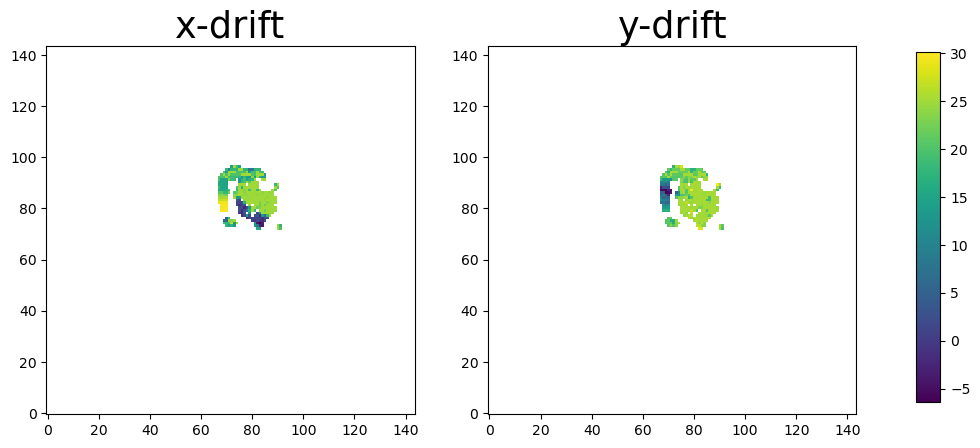

In [25]:
# Plot ice drift

driftx = ma.asarray(idrift['drift_x'])
driftx.mask = driftx < -1e9
drifty = ma.asarray(idrift['drift_y'])
drifty.mask = drifty < -1e9

fig = plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(1,2,1)
c1 = ax1.imshow(driftx[:], interpolation = 'none', origin='lower', cmap=cmap)
ax1.set_title("x-drift")
ax2 = fig.add_subplot(1,2,2)
c2 = ax2.imshow(drifty[:], interpolation = 'none', origin='lower', cmap=cmap)
ax2.set_title("y-drift")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.25, 0.02, 0.5])
fig.colorbar(c1, cax=cbar_ax, shrink=0.5)

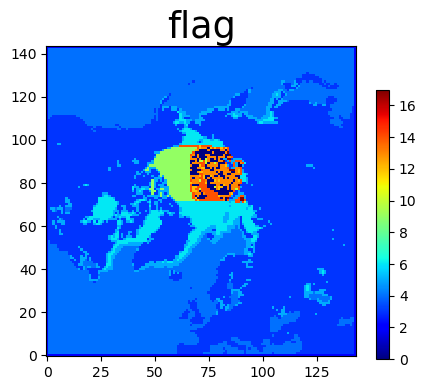

In [26]:
# Plot ice drift flags

cmap = cm.jet
fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(1,1,1)
c1 = ax1.imshow(idrift['flag'][:], interpolation = 'none', origin='lower', cmap=cmap)
ax1.set_title("flag")
fig.colorbar(c1, ax=ax1, location='right', anchor=(0, 0.3), shrink=0.7)

In [ ]:
# Will need to alter icedrift code so that the forward and backward scans are treated the same as the 
# H and V polarisations, and combined within the drift algorithm. Note that the forward and backward scans are 
# actually separated by 7 minutes, so later on we can try to use the time shift between these too.

## Step 3: Detection and correction of rogue vectors
